In [1]:
import os
import pydicom
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist
from scipy.ndimage import gaussian_filter1d
from scipy.signal import deconvolve
from scipy.signal import convolve
from scipy.special import gamma
from scipy.optimize import minimize

In [2]:
dcm_path = '/Users/juntangwang/Desktop/SRS00013/IMG00001.DCM'
folder_path = '/Users/juntangwang/Desktop/SRS00013/'  # Update this to the path of your DICOM folder

In [3]:
def time_to_seconds(t):
    """Converts a time string in HHMMSS.fff format to seconds."""
    hours, minutes, seconds = int(t[:2]), int(t[2:4]), float(t[4:])
    return 3600 * hours + 60 * minutes + seconds

dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.DCM')]

# Initialize a list to hold your image data
image_data = []
acquisition_times = []
image_positions = []

acquisition_numbers =[]
instance_numbers = []

for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    
    # Preprocess the image as necessary. This is just a placeholder for any actual preprocessing you need to do.
    # For example: image = preprocess(ds.pixel_array)
    image_data.append(equalize_adapthist(gaussian(ds.pixel_array, sigma=1)))
    # image_data.append(ds.pixel_array)
    
    # Extract acquisition time; note that you'll need to adjust 'AcquisitionTime' based on your DICOM files' metadata structure
    acquisition_times.append(time_to_seconds(ds.AcquisitionTime))
    image_positions.append(ds.ImagePositionPatient)
    
    acquisition_numbers.append(ds.AcquisitionNumber)
    instance_numbers.append(ds.InstanceNumber)
    
image_data = np.array(image_data)
image_positions = np.array(image_positions)
acquisition_times = np.array(acquisition_times)

# Assuming these are your original lists:
# image_data = [np.array(...) for _ in range(1000)]  # Each a 256x256 numpy array
# image_position = [np.array(...) for _ in range(1000)]  # Each a 1x3 numpy array
# acquisition_time = [np.random.rand() for _ in range(1000)]  # Each a random float

# Step 1: Combine the lists into a single list of tuples
combined = list(zip(image_data, image_positions, acquisition_times, acquisition_numbers, instance_numbers))

# combined.sort(key=lambda x: x[-1])

combined.sort(key=lambda x: x[2])
# Step 2: Sort the combined list by the image_position (assuming it's the second element of the tuple)
combined.sort(key=lambda x: x[1][1])  # Adjust the lambda function if sorting criteria are different

# Step 3: Separate the combined list back into three lists
image_data_sorted, image_position_sorted, acquisition_time_sorted, acquisition_numbers_sorted, instance_numbers_sorted = zip(*combined)

# If you need the results to be in list format instead of tuples (especially for the image data), you can convert them
# image_data_sorted = list(equalize_adapthist(gaussian(np.array(image_data_sorted) , sigma=1)))
image_data_sorted = list(image_data_sorted)
image_position_sorted = list(image_position_sorted)
acquisition_time_sorted = list(acquisition_time_sorted)
acquisition_numbers_sorted = list(acquisition_numbers_sorted)
instance_numbers_sorted = list(instance_numbers_sorted)

RT: 1590
TE: 32
flip angle: 90

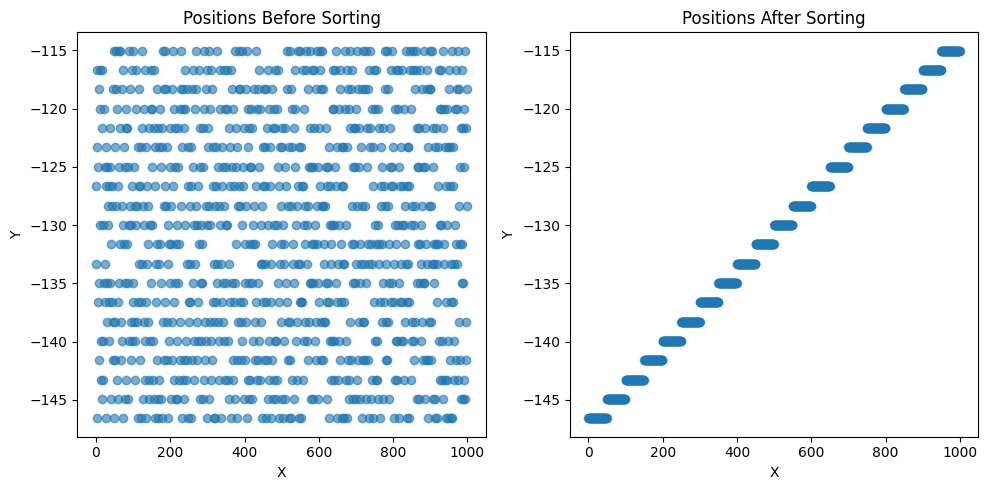

In [4]:
a = []
for i in range(len(image_data_sorted)):
    a.append(i)
    
a = np.asarray(a)
# Assuming image_position and image_position_sorted are your original and sorted position lists respectively

# Convert lists to numpy arrays for easier slicing
original_positions = np.array(image_positions)
sorted_positions = np.array(image_position_sorted)

# Before sorting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(a[:], original_positions[:, 1], alpha=0.6)
plt.title('Positions Before Sorting')
plt.xlabel('X')
plt.ylabel('Y')

# After sorting
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(a[:], sorted_positions[:, 1], alpha=0.6)
plt.title('Positions After Sorting')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

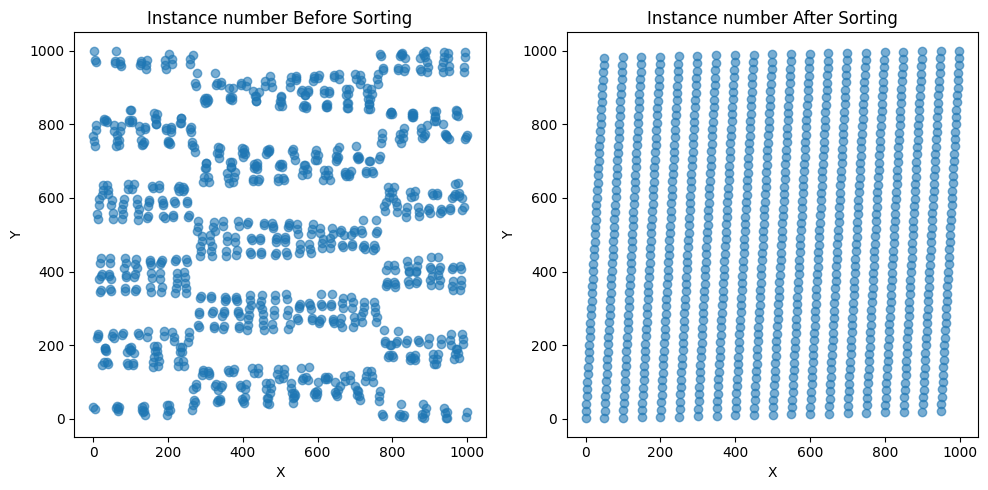

In [5]:
a = []
for i in range(len(image_data_sorted)):
    a.append(i)
    
a = np.asarray(a)
# Assuming image_position and image_position_sorted are your original and sorted position lists respectively

# Convert lists to numpy arrays for easier slicing
original_positions = np.array(instance_numbers)
sorted_positions = np.array(instance_numbers_sorted)

# Before sorting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(a[:], original_positions[:], alpha=0.6)
plt.title('Instance number Before Sorting')
plt.xlabel('X')
plt.ylabel('Y')

# After sorting
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(a[:], sorted_positions[:], alpha=0.6)
plt.title('Instance number After Sorting')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

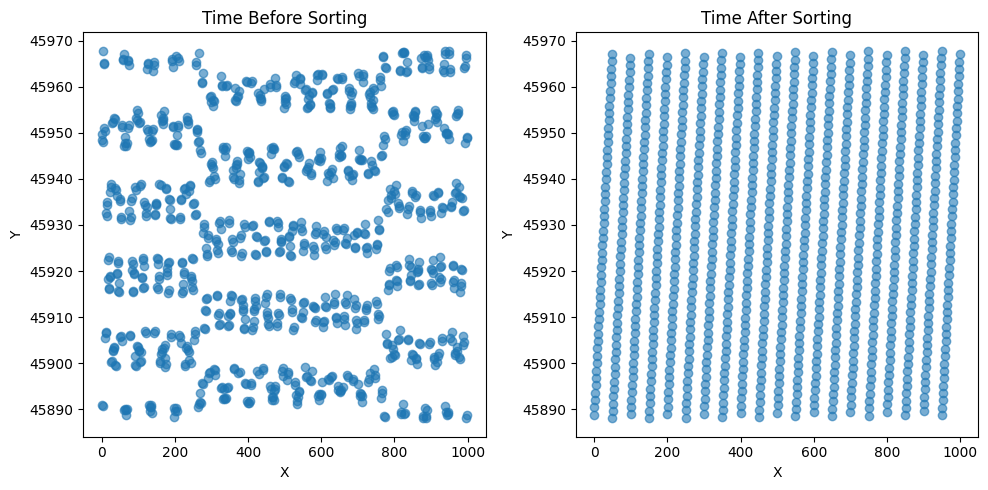

In [6]:
a = []
for i in range(len(image_data_sorted)):
    a.append(i)
    
a = np.asarray(a)
# Assuming image_position and image_position_sorted are your original and sorted position lists respectively

# Convert lists to numpy arrays for easier slicing
original_positions = np.array(acquisition_times)
sorted_positions = np.array(acquisition_time_sorted)

# Before sorting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(a[:], original_positions[:], alpha=0.6)
plt.title('Time Before Sorting')
plt.xlabel('X')
plt.ylabel('Y')

# After sorting
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(a[:], sorted_positions[:], alpha=0.6)
plt.title('Time After Sorting')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

In [7]:
def intensity_to_concentration(intensity, baseline=None):
    
    if baseline is None:
        baseline = np.average(intensity[6:8]) #TODO: Baseline modeling
    
    baseline = baseline + np.min(baseline)
    
    # Placeholder values for demonstration
    te = 32  # Echo time in milliseconds (ms)
    s0 = baseline  # Baseline signal intensity before contrast injection
    st = intensity  # Signal intensity at different times after contrast injection

    # Calculating contrast agent concentration using the provided formula
    # ct = (1/te) * np.log(st/s0)
    ct = 1/st
    return ct

def plt_point(x,y,z,view=False):
    times = acquisition_time_sorted[50*(z-1):50*z]-acquisition_time_sorted[50*(z-1)]
    concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y])
    if view:
        print("InstanceNumbers: ")
        print(instance_numbers_sorted[50*(z-1):50*z])
        print("AcquisitionNumbers: ")
        print(acquisition_numbers_sorted[50*(z-1):50*z])
        print("unique image_positions: ")
        print(np.unique(image_position_sorted[50*(z-1):50*z]))
    
    # Assuming 'concentration' and 'time_points' are your data arrays
    plt.figure(figsize=(10, 6))
    plt.plot(times, concentrations, '-o', label='Concentration over Time')
    plt.title(f'Concentration vs. Time at <{x},{y},{z}>*\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Interactive visualization of 3D data over time
def explore_3dimage_time(i=0,z=0,x=0,y=0,vis=False,aif=False):
    if vis:
        i = (z-1)*50+i
        plt.figure(figsize=(10, 5))
        plt.imshow(image_data_sorted[i, :, :], cmap='gray')  # Adjust the 15 here to show different slices
        plt.title(f'#: {instance_numbers_sorted[i]} Position: {image_position_sorted[i]} \n T#: {acquisition_numbers_sorted[i]} Time: {acquisition_time_sorted[i]}')
        plt.axis('off')
        plt.scatter(x, y, color='red', s=10)  # Highlight the point
        plt.show()
    if aif: 
        plt_point(x,y,z)

In [8]:
# Assuming 'image_series' is a 4D numpy array [time, z, x, y]
# where 'time' is the 4th dimension (different acquisition times)
image_data_sorted = np.array(image_data_sorted)

# Create a slider to move through time
interact(explore_3dimage_time, 
         i=IntSlider(min=0, max=49, step=1, value=0), 
         z=IntSlider(min=1,max=20,step=1, value=1),
         x=IntSlider(min=0, max=255, step=1),
         y=IntSlider(min=0, max=255, step=1),
         vis=True,
         aif=True)


interactive(children=(IntSlider(value=0, description='i', max=49), IntSlider(value=1, description='z', max=20,…

<function __main__.explore_3dimage_time(i=0, z=0, x=0, y=0, vis=False, aif=False)>

C(t) =(1/TE)*ln(S(t)/S0), where TE is the echo time, S(t) is the signal intensity at each timepoint during the gamma fitting period and S0 is the average baseline signal intensity

In [9]:
def smooth_data_gaussian(data, sigma=1):
    """
    Smooths the data using a Gaussian filter.

    :param data: The input data to smooth.
    :param sigma: The standard deviation for the Gaussian kernel.
    :return: The smoothed data.
    """
    return gaussian_filter1d(data, sigma)

def plt_pointss(xyztuples=None, view=False, smooth=False, legend_on=False):
    if xyztuples is None:
        xyztuples = [(0, 0, 0)]
    plt.figure(figsize=(10, 6))
    
    for i, (x, y, z) in enumerate(xyztuples):
        times = acquisition_time_sorted[50*(z-1):50*z] - acquisition_time_sorted[50*(z-1)]
        concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y])
        
        # Smooth the concentration data using Gaussian filter
        if smooth:
            smoothed_concentrations = smooth_data_gaussian(concentrations)
        else:
            smoothed_concentrations = concentrations.copy()

        if view:
            print(f"Data for {x},{y},{z}")
            print("InstanceNumbers: ")
            print(instance_numbers_sorted[50*(z-1):50*z])
            print("AcquisitionNumbers: ")
            print(acquisition_numbers_sorted[50*(z-1):50*z])
            print("unique image_positions: ")
            print(np.unique(image_position_sorted[50*(z-1):50*z]))
            print()  # Print a newline for readability
        
        plt.plot(times, smoothed_concentrations, '-o', label=f'<{x},{y},{z}>')
    
    plt.title('Smoothed Concentration vs. Time for Multiple Points\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    if legend_on:    
        plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# xyztuples = [(x1, y1, z1), (x2, y2, z2), ...]
# plt_points(xyztuples, view=True)

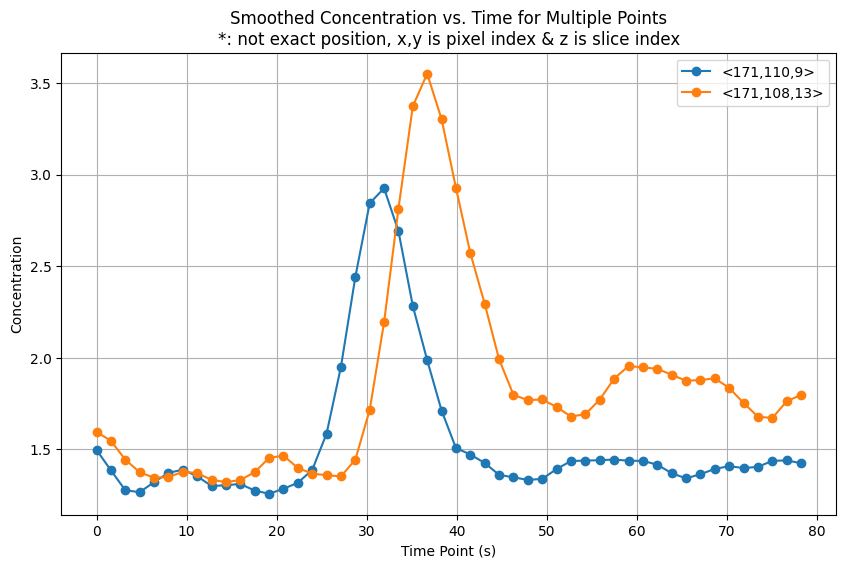

In [10]:
xyztuples = [  
    (171,110,9),
    
    # (173,103,13),
    # (173,104,13),
    (171,108,13)
    ]
plt_pointss(xyztuples,smooth=True, legend_on=True)


In [11]:
def test_around(x0,y0,z0,r=5,s=False, l=False):
    xyztuples=[]
    for x in range(x0-r,x0+r+1):
        for y in range(y0-r,y0+r+1):
            xyztuples.append((x,y,z0))
    plt_pointss(xyztuples, smooth=s, legend_on=l)

r = 3

interact(test_around,
         z0=IntSlider(min=1,max=20,step=1, value=1),
         x0=IntSlider(min=r, max=255-r, step=1),
         y0=IntSlider(min=r, max=255-r, step=1),
         r=r,
         l=False
         )

interactive(children=(IntSlider(value=3, description='x0', max=252, min=3), IntSlider(value=3, description='y0…

<function __main__.test_around(x0, y0, z0, r=5, s=False, l=False)>

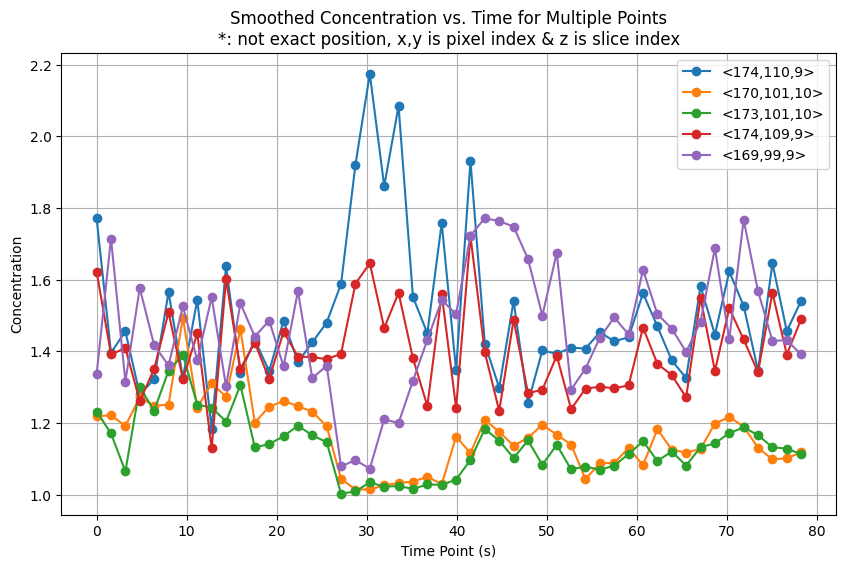

In [12]:
xyztuples = [
    (174,110,9),
    (170,101,10),

    (173,101,10),
    (174,109,9),

    (169,99,9)
    ]
plt_pointss(xyztuples, legend_on=True)

In [13]:
def read_point4time(x,y,z):
    """Read time points for a given slice."""
    return acquisition_time_sorted[50*(z-1):50*z] - acquisition_time_sorted[50*(z-1)]

def read_point4concentration(x, y, z):
    """Read concentration data for a given point."""
    return intensity_to_concentration(image_data_sorted[50*(z-1):50*z, x, y])
    
    

R(t): [1.00622971]
Tissue blood flow (F): (50,)


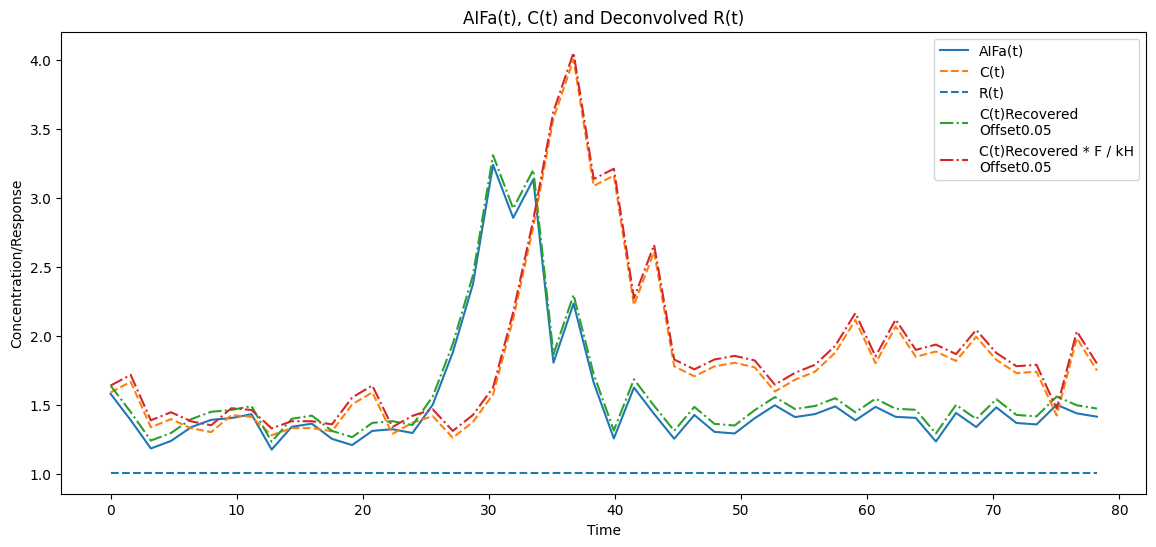

In [14]:
def calculate_r_f(aif_concentration, tissue_concentration):
    """
    Calculate R(t) and F for multiple tissue points.
    
    :param aif_concentration: Tuple containing the concentration of the AIF pixel (x, y, z).
    :param tissue_concentration: Tuple containing the concentration of the tissue pixel (x, y, z).
    :return: A dictionary with tissue point coordinates as keys and (R_t, F) tuples as values.
    """
    # Define the hematocrit correction factor kH
    Ha = 0.45  # Typical arterial hematocrit
    Ht = 0.25  # Typical tissue hematocrit        
    kH = (1 - Ha) / (1 - Ht)
        
    # Apply deconvolution
    R_t, remainder = deconvolve(tissue_concentration, aif_concentration)
    F = (1 + remainder / convolve(aif_concentration, R_t)) *kH
            
    return R_t, F

# Example usage
# aif_pixel = (169, 99, 9)  # AIF pixel coordinates
# tissue_pixel = (173, 101,10)

aif_pixel = (171,110,9)
tissue_pixel = (171,108,13)

R_t, F_t= calculate_r_f(read_point4concentration(*aif_pixel),read_point4concentration(*tissue_pixel))

print(f"R(t):", R_t)
print(f"Tissue blood flow (F):", F_t.shape)

time = read_point4time(*tissue_pixel)

# Define the hematocrit correction factor kH
Ha = 0.45  # Typical arterial hematocrit
Ht = 0.25  # Typical tissue hematocrit        
kH = (1 - Ha) / (1 - Ht)

AIFa_t = read_point4concentration(*aif_pixel)
C_t = read_point4concentration(*tissue_pixel)
Cr = np.convolve(AIFa_t, R_t, mode='full')

plt.figure(figsize=(14, 6))
plt.plot(time, AIFa_t, label='AIFa(t)')
plt.plot(time, C_t, label='C(t)', linestyle='--')
plt.hlines(R_t, xmin=0,xmax=max(time),label='R(t)', linestyle='--')
plt.plot(time, Cr + 0.05, label='C(t)Recovered\nOffset0.05', linestyle='-.')
plt.plot(time, Cr * F_t / kH + 0.05, label='C(t)Recovered * F / kH\nOffset0.05', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Concentration/Response')
plt.legend()
plt.title('AIFa(t), C(t) and Deconvolved R(t)')
plt.show()

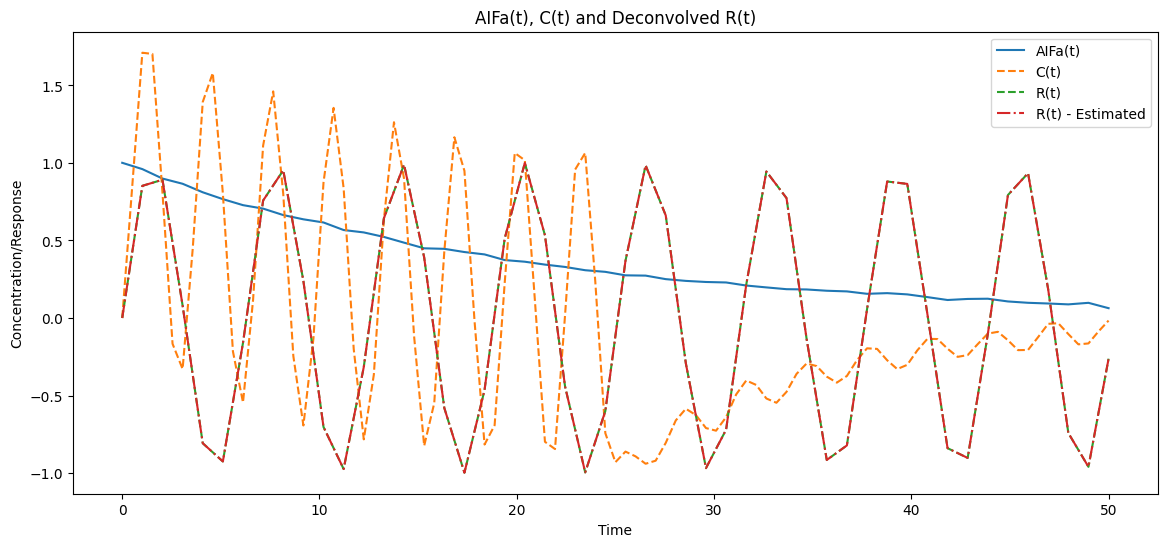

In [15]:
# Time array
time = np.linspace(0, 50, 50)
time1 = np.linspace(0,50,99)

R_t = np.sin(time)

# Simulate AIFa(t) as an exponential decay function
AIFa = np.exp(-0.05 * time) + np.random.normal(0, 0.01, len(time))

# Simulate C(t) as a scaled and delayed version of AIFa(t)
C = convolve(AIFa, R_t, mode='full')

quotient, reminder = deconvolve(C, AIFa)

R = quotient

plt.figure(figsize=(14, 6))
plt.plot(time, AIFa, label='AIFa(t)')
plt.plot(time1, C, label='C(t)', linestyle='--')
plt.plot(time, R_t,label='R(t)', linestyle='--')
plt.plot(time, R, label='R(t) - Estimated', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Concentration/Response')
plt.legend()
plt.title('AIFa(t), C(t) and Deconvolved R(t)')
plt.show()


In [16]:
# Example points to draw
points = [aif_pixel, tissue_pixel] # Example points

# Function to draw the slices with points
def draw_slices_with_points(i=0):
    fig, axes = plt.subplots(4, 5, figsize=(10, 8)) # Adjust the subplot grid if needed
    axes = axes.flatten()
    
    for z in range(1, 21): # Assuming you have 20 slices
        ax = axes[z-1]
        img_index = (z-1) * 50 + i # Calculate the index of the image to show
        ax.imshow(image_data_sorted[img_index, :, :], cmap='gray')
        
        # Draw the specified points for the current slice
        for x, y, slice_z in points:
            if slice_z == z: # Check if the point belongs to the current slice
                ax.scatter(x, y, color='red', s=10)
        
        ax.set_title(f'Slice #{z}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create a slider to interact with the function
interact(draw_slices_with_points, i=IntSlider(min=0, max=49, step=1, value=20))

interactive(children=(IntSlider(value=20, description='i', max=49), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_slices_with_points(i=0)>

In [17]:
# Define the gamma variate function (GVF) according to your parameters
def gamma_variate_function(t, A1, alpha1, sigma1, t1):
    return (1 / A1) * ((t - t1) ** alpha1) * np.exp(-(t - t1) / sigma1) if t >= t1 else 0

# Estimated parameters (example values, you need to calculate these from your data)
td = 5
# Estimated from your dataa
alpha1 = 0   # Estimated from your dataa
beta1 = 0.12 # Given
t1 = td*(1-beta1)
sigma1 = t1 * beta1 / (1-beta1)
A1 = sigma1**(1+alpha1) * gamma(1+alpha1)   # 

time = read_point4time(*tissue_pixel)

# Apply the GVF to your time vector
ha_t = []

for t in time:
    ha_t.append(gamma_variate_function(t, A1,alpha1,sigma1,t1))

# Your AIFa(t) data (replace this with your actual data)
AIFa_t = AIFa_t  # Example data

# Convolve AIFa(t) with ha(t) to get AIFt(t)
AIFt_t = convolve(AIFa_t, ha_t)

# Since the convolution extends beyond the original signal length, you may want to trim it
AIFt_t = AIFt_t[:len(time)]

# Now AIFt_t contains the arterial input function at the tissue of interest

<function matplotlib.pyplot.show(close=None, block=None)>

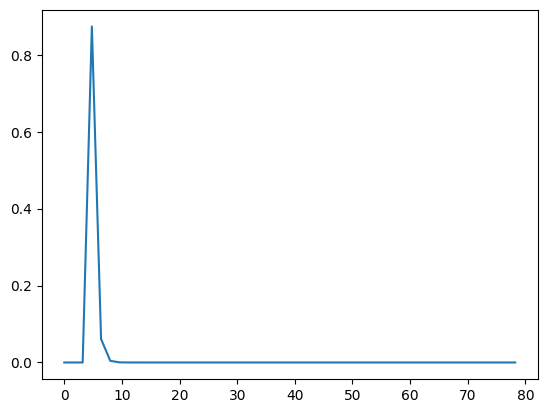

In [18]:
plt.plot(time, ha_t)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

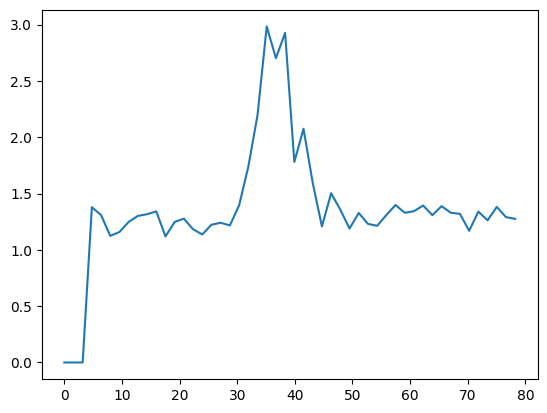

In [19]:
plt.plot(time, AIFt_t)
plt.show

Re(t): [1.41913935]
Tissue blood flow (Ft): (50,)


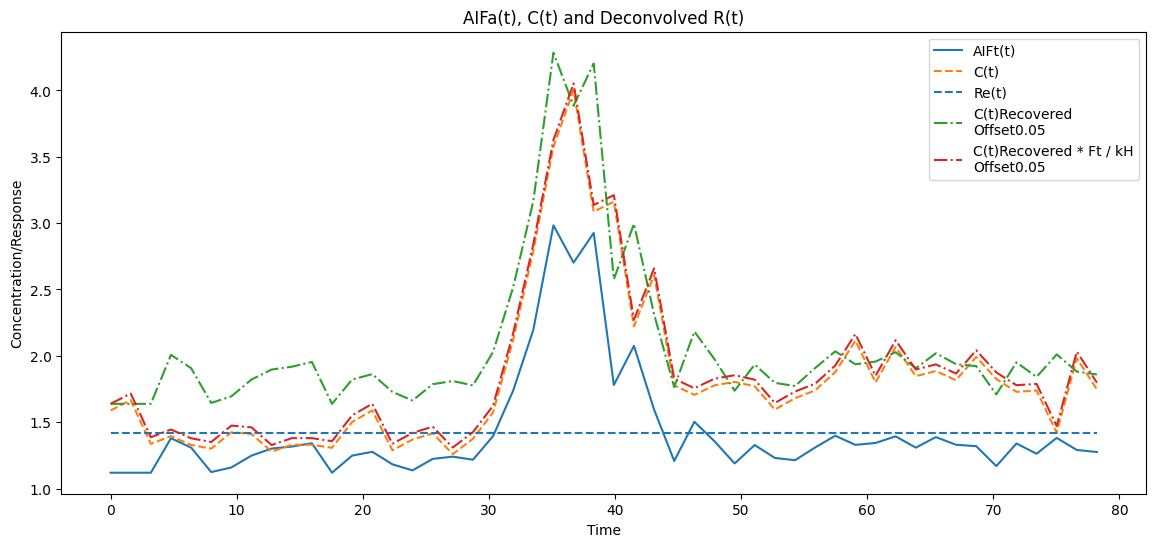

In [20]:
tissue_pixel = (171,108,13)

newAIFt_t = []
low = max(AIFt_t)
for point in AIFt_t:
    if point != 0: low = min(point, low)
    
for point in AIFt_t:
    if point == 0: newAIFt_t.append(low)
    else: newAIFt_t.append(point)

Re_t, Ft_t= calculate_r_f(newAIFt_t, read_point4concentration(*tissue_pixel))

print(f"Re(t):", Re_t)
print(f"Tissue blood flow (Ft):", Ft_t.shape)

time = read_point4time(*tissue_pixel)

# Define the hematocrit correction factor kH
Ha = 0.45  # Typical arterial hematocrit
Ht = 0.25  # Typical tissue hematocrit        
kH = (1 - Ha) / (1 - Ht)

C_t = read_point4concentration(*tissue_pixel)
Cr = np.convolve(newAIFt_t, Re_t, mode='full') 

plt.figure(figsize=(14, 6))
plt.plot(time, newAIFt_t, label='AIFt(t)')
plt.plot(time, C_t, label='C(t)', linestyle='--')
plt.hlines(Re_t, xmin=0,xmax=max(time),label='Re(t)', linestyle='--')
plt.plot(time, Cr + 0.05, label='C(t)Recovered\nOffset0.05', linestyle='-.')
plt.plot(time, Cr * Ft_t / kH + 0.05, label='C(t)Recovered * Ft / kH\nOffset0.05', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Concentration/Response')
plt.legend()
plt.title('AIFa(t), C(t) and Deconvolved R(t)')
plt.show()

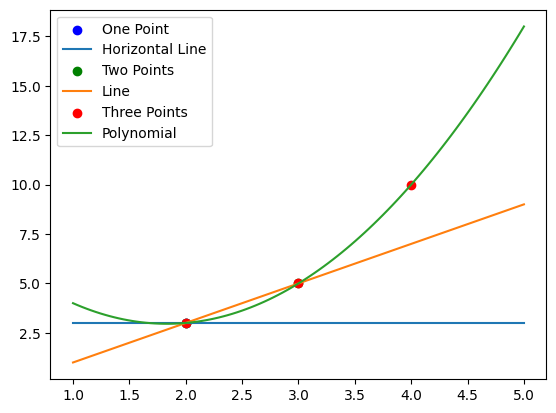

In [21]:
def fit_curve(points):
    x_coords, y_coords = zip(*points)
    degree = len(points) - 1

    if degree == 0:
        # Only one point: plot a horizontal line.
        hline = np.poly1d([0, y_coords[0]])
        return hline
    elif degree == 1:
        # Two points: fit a line.
        coefficients = np.polyfit(x_coords, y_coords, 1)
        line = np.poly1d(coefficients)
        return line
    else:
        # Three or more points: fit a polynomial.
        coefficients = np.polyfit(x_coords, y_coords, degree)
        polynomial = np.poly1d(coefficients)
        return polynomial

# Example points
points_one = [(2, 3)]  # One point
points_two = [(2, 3), (3, 5)]  # Two points
points_three = [(2, 3), (3, 5), (4, 10)]  # Three points

# Fit curves
curve_one = fit_curve(points_one)
curve_two = fit_curve(points_two)
curve_three = fit_curve(points_three)

# Plotting
x_range = np.linspace(1, 5, 100)  # Change the range according to your data points

plt.figure()
plt.scatter(*zip(*points_one), color='blue', label='One Point')
plt.plot(x_range, curve_one(x_range), label='Horizontal Line')

plt.scatter(*zip(*points_two), color='green', label='Two Points')
plt.plot(x_range, curve_two(x_range), label='Line')

plt.scatter(*zip(*points_three), color='red', label='Three Points')
plt.plot(x_range, curve_three(x_range), label='Polynomial')

plt.legend()
plt.show()

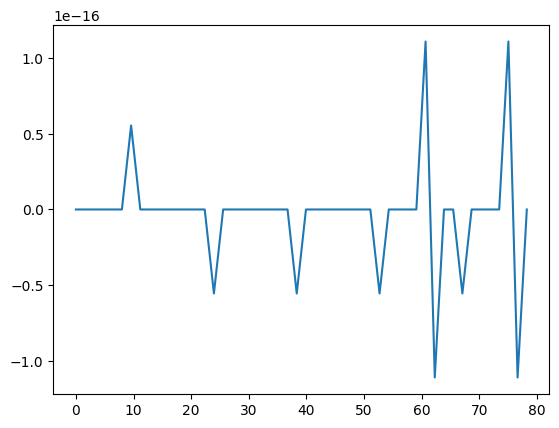

In [22]:
points = []
i = 0
for point in Re_t:
    points.append((i,point))
    i = i+1

Re_t_f = fit_curve(points)
newRe_t = Re_t_f(time)

# Calculate the derivative of R(t) to get h_t
he_t = -np.gradient(newRe_t, time)

# Now h_t will be your estimated transport function
plt.plot(time, he_t, '')

In [23]:
prt = 35
mtt = 40

t2 = 0 #Assuming

sigma2 = mtt - prt #7b
alpha2 = prt / sigma2 #7b

A2 = sigma2**(1+alpha2) * gamma(1+alpha2)   # 

time = read_point4time(*tissue_pixel)

# Apply the GVF to your time vector
hs_t = []

for t in time:
    hs_t.append(gamma_variate_function(t, A2, alpha2, sigma2, t2))

# hs_t would be your array of h_s(t) values
# time would be your array of time points that correspond to the h_s(t) values

def Rs(t, hs_t, time):
    # Find the index up to which you need to integrate
    index = np.where(time <= t)[0][-1] # This gets the last index where time is less than or equal to t
    # Calculate the integral up to that index
    integral = np.trapz(hs_t[:index+1], time[:index+1])
    # Subtract from 1 as per your formula
    return 1 - integral

Rs_t = []
for t in time:
    Rs_t.append(Rs(t, hs_t, time))
Rs_t = np.array(Rs_t)

# Your AIFa(t) data (replace this with your actual data)
AIFt_t = AIFt_t  # Example data

Cs_t = (Ft_t/kH)*convolve(AIFt_t, Rs_t, mode='same')

In [24]:
# Function representing the model C_s(t), which depends on your parameters
# For example, let's say we have a simple model with parameters p1, p2, ..., p7

Ft_t = np.array(Ft_t)

def Cs_model(time, t1, sigma1, alpha1, sigma2, alpha2, t2, *Ft_t_values):
    AIFa_t = read_point4concentration(*aif_pixel)
    Ft_t = np.array(Ft_t_values)
    
    A1 = sigma1**(1+alpha1) * gamma(1+alpha1)   # 
    # Apply the GVF to your time vector
    ha_t = []
    
    for t in time:
        ha_t.append(gamma_variate_function(t, A1,alpha1,sigma1,t1))
    
    # Convolve AIFa(t) with ha(t) to get AIFt(t)
    AIFt_t = convolve(AIFa_t, ha_t)
    
    # Since the convolution extends beyond the original signal length, you may want to trim it
    AIFt_t = AIFt_t[:len(time)]

    # Now AIFt_t contains the arterial input function at the tissue of interest
    
    A2 = sigma2**(1+alpha2) * gamma(1+alpha2)   # 
    
    # Apply the GVF to your time vector
    hs_t = []
    for t in time:
        hs_t.append(gamma_variate_function(t, A2, alpha2, sigma2, t2))

    Rs_t = []
    for t in time:
        Rs_t.append(Rs(t, hs_t, time))
    Rs_t = np.array(Rs_t)
    
    Cs_t = (Ft_t/kH)*convolve(AIFt_t, Rs_t, mode='same')
    
    return Cs_t# ... the modelled C_s(t) ...

def cost_function(params, time, C_t_measured):
    # Unpack your parameters (last one is Ft_t array)
    t1, sigma1, alpha1, sigma2, alpha2, t2 = params[:-len(time)]
    Ft_t_values = params[-len(time):]  # Ft_t values are the last part of the params array
    
    # Calculate the model Cs_t values
    Cs_t = Cs_model(time, t1, sigma1, alpha1, sigma2, alpha2, t2, *Ft_t_values)
    
    # Calculate the cost as the sum of squared differences
    cost = np.sum((Cs_t - C_t_measured) ** 2)
    return cost

# Initial guesses for parameters other than Ft_t
initial_guesses = [t1, sigma1, alpha1, sigma2, alpha2, t2]
# Extend initial guesses with the initial values of Ft_t array
initial_guesses.extend(Ft_t)

# Perform the optimization
result = minimize(cost_function, initial_guesses, args=(time, C_t), method='L-BFGS-B')

# Optimized parameters
optimized_parameters = result.x[:-len(time)]  # The first parameters
optimized_Ft_t = result.x[-len(time):]  # The Ft_t array values



In [25]:
# Unpacking the optimized parameters
t1, sigma1, alpha1, sigma2, alpha2, t2 = optimized_parameters
Ft = optimized_Ft_t

# Blood Flow (BF) is equal to Ft
BF = Ft

# Mean Transit Time (MTT)
MTT = t2 + sigma2 * (1 + alpha2)

# Blood Volume (BV) is product of BF and MTT
BV = BF * MTT

# Arterial Delay Time (DT)
DT = t1 + sigma1 * (1 + alpha1)

# Arterial Dispersion Time (ADT)
ADT = sigma1 * np.sqrt(1 + alpha1)

# Tissue Dispersion Time (TDT)
TDT = sigma2 * np.sqrt(1 + alpha2)

# Relative Arterial Dispersion (RAD)
RAD = ADT / DT

# Relative Tissue Dispersion (RTD)
RTD = TDT / MTT

# Now you can print or return these calculated perfusion indices
print("Blood Flow (BF):", BF)
print("Mean Transit Time (MTT):", MTT)
print("Blood Volume (BV):", BV)
print("Arterial Delay Time (DT):", DT)
print("Arterial Dispersion Time (ADT):", ADT)
print("Tissue Dispersion Time (TDT):", TDT)
print("Relative Arterial Dispersion (RAD):", RAD)
print("Relative Tissue Dispersion (RTD):", RTD)

# If you need to use these values in subsequent calculations, you might want to return them
perf_indices = {
    "BF": BF,
    "MTT": MTT,
    "BV": BV,
    "DT": DT,
    "ADT": ADT,
    "TDT": TDT,
    "RAD": RAD,
    "RTD": RTD
}

# Return or store the dictionary as needed for further use


Blood Flow (BF): [0.56012883 0.56093051 0.42709016 0.43024631 0.40037349 0.38038707
 0.40667592 0.39572979 0.3511701  0.35948881 0.35432298 0.3429225
 0.38774496 0.40509345 0.32450617 0.34097947 0.34984448 0.3082926
 0.3344235  0.38087977 0.5130568  0.67276317 0.86141889 0.9618338
 0.74211035 0.76098807 0.55049127 0.66604797 0.46835026 0.46589524
 0.50382432 0.5310798  0.54236115 0.50921118 0.56027992 0.60648871
 0.68576116 0.81026164 0.72544187 0.8781617  0.82861517 0.8951553
 0.91517881 1.06773138 1.04339298 1.05787957 1.14398315 1.01076389
 1.53585534 1.47761066]
Mean Transit Time (MTT): 53.75384640848832
Blood Volume (BV): [30.10907887 30.1521723  22.95773912 23.12739422 21.52161526 20.44726806
 21.86039511 21.27199849 18.87674346 19.32390623 19.04622294 18.43340325
 20.84278291 21.77533112 17.44345463 18.32895827 18.80548669 16.57191302
 17.97654963 20.47375246 27.57877655 36.163608   46.30457868 51.70226614
 39.89128574 40.90603584 29.59102302 35.80264039 25.17562788 25.04366101


Blood Flow (BF): Usually reported in milliliters per gram of tissue per minute (mL/100g/min). It represents the volume of blood flowing through 100 grams of tissue per minute.
Mean Transit Time (MTT): Typically measured in seconds (s), this is the average time taken for blood to pass through a given volume of tissue.
Blood Volume (BV): Usually measured in milliliters of blood per 100 grams of tissue (mL/100g), indicating the volume of blood in the given volume of tissue.
Arterial Delay Time (DT): Also typically measured in seconds (s), it represents the delay between the arterial input function (AIF) and the tissue response.
Arterial Dispersion Time (ADT): Measured in seconds (s), it quantifies the spread or dispersion of the arterial input through the vascular tree before reaching the tissue.
Tissue Dispersion Time (TDT): Measured in seconds (s), it describes the dispersion of blood flow within the tissue itself.
Relative Arterial Dispersion (RAD) and Relative Tissue Dispersion (RTD): These are dimensionless ratios (they have no units) since they represent the proportion of the dispersion relative to another time measure (like delay time or mean transit time).